In [1]:
from bayesByBackprop import ShuffleNetV2, GaussianVariationalInference
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import os
import sys
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def cycle_lr(lr_max, num_steps):
    lr_min = lr_max * 1e-1
    _num_steps = int(num_steps * .9)
    first_step = _num_steps // 2
    second_step = _num_steps - first_step
    last_step = num_steps - _num_steps
    yo = np.empty(num_steps)
    yo[:first_step] = np.linspace(lr_min, lr_max, first_step)
    yo[first_step:_num_steps] = np.linspace(lr_max, lr_min, second_step)
    yo[_num_steps:] = np.linspace(lr_min, lr_min * 1e-4, last_step)
    return yo

def cycle_momenthum(mom_min, mom_max, num_steps):
    _num_steps = int(num_steps * .9)
    first_step = _num_steps // 2
    second_step = _num_steps - first_step
    last_step = num_steps - _num_steps
    yo = np.empty(num_steps)
    yo[:first_step] = np.linspace(mom_max, mom_min, first_step)
    yo[first_step:_num_steps] = np.linspace(mom_min, mom_max, second_step)
    yo[_num_steps:] = mom_max
    return yo

In [3]:
class LrSchedulerFinder(_LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, num_steps):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.num_steps = num_steps
        self.q = (lr_max / lr_min) ** (1 / (num_steps - 1))
        super().__init__(optimizer=optimizer, last_epoch=-1)

    def get_lr(self):
        return [base_lr * self.q ** (self.last_epoch + 1)
                for base_lr in self.base_lrs]


def find_lr(dataloader: DataLoader, model: nn.Module, optimizer: torch.optim, criterion, device, num_steps,
            lr_min: float = 1e-7, lr_max: float = 10, beta: float = 0.98):
    model.to(device)
    optim_dict = optimizer.state_dict().copy()
    optimizer.param_groups[0]['lr'] = lr_min
#     num_steps = len(dataloader) - 1
    scheduler = LrSchedulerFinder(optimizer, lr_min, lr_max, num_steps)
    model_dict = model.state_dict().copy()
    losses = list()
    lrs = list()
    avg_loss = 0
    best_loss = 0
    for idx_batch, (data, label) in tqdm(enumerate(dataloader, 1), total=num_steps):
        if idx_batch == num_steps:
            break
        y, kl = model(data.to(device))
        loss = criterion(y, label, kl, 0)
        if np.isnan(loss.item()):
            break
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smooth_loss = avg_loss / (1 - beta ** idx_batch)
        if idx_batch > 1 and smooth_loss > 4 * best_loss:
            break
        if smooth_loss < best_loss or idx_batch == 1:
            best_loss = smooth_loss
        losses.append(smooth_loss)
        lrs.append(scheduler.get_lr()[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    model.load_state_dict(model_dict)
    optimizer.load_state_dict(optim_dict)
    return np.array(lrs), np.array(losses)

In [4]:
class cycleScheduler():
    def __init__(self, optimizer, num_iterations, lr_max, mom_min=.85, mom_max=.95):
        self.optimizer = optimizer
        self.lr_max = lr_max
        self.mom_min = mom_min
        self.mom_max = mom_max
        self.num_iterations = num_iterations
        self.it = 0
        self.cycle_lr = cycle_lr(lr_max, num_iterations)
        self.cycle_mom = cycle_momenthum(mom_min=mom_min, mom_max=mom_max, num_steps=num_iterations)
        assert self.cycle_lr.shape == self.cycle_mom.shape
        for param in self.optimizer.param_groups:
            param["lr"] = self.cycle_lr[self.it]
            if "momentum" in param:
                break
            elif "betas" in param:
                _, beta2 = param["betas"]
                break
            else:
                raise AttributeError(f"cycleScheduler is implemented for optimizer with "
                                     f"momentum ,and {self.optimizer.__class__.__name__} doesnt use it")

    def step(self):
        for param in self.optimizer.param_groups:
            param["lr"] = self.cycle_lr[self.it]
            if "momentum" in param:
                param["momentum"] = self.cycle_mom[self.it]
            else:
                _, beta2 = param["betas"]
                param["betas"] = self.cycle_mom[self.it], beta2

        self.it += 1

In [5]:
class OneCycleModel():
    def __init__(self, dataloader, valoader, model, device, optimizer, criterion, cycle_len):
        self.dataloader = dataloader
        self.valoader = valoader
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.cycle_len = cycle_len
        self.device = device
        self.lrs = None
        self.losses = None
        self.best_lr = None
        self.num_iterations = len(dataloader) * cycle_len
        
    
    def lr_find(self, num_steps: int=100, lr_min: float = 1e-8, lr_max: float = 10, beta: float = 0.98, show=False):
        self.lrs, self.losses = find_lr(self.dataloader, self.model, self.optimizer, self.criterion, self.device,
                                        num_steps, lr_min=lr_min, lr_max=lr_max, beta=beta)
        argmin = self.losses.argmin()
        diff_losses = np.diff(self.losses[:argmin])
        self.idx = diff_losses.argmin()
        self.best_lr = self.lrs[self.idx]
        self.agressive = self.lrs[argmin]
        self.compromise = self.lrs[(self.idx + argmin)//2]
        if show:
            markers = [(f"best: {self.best_lr:.3f}", self.idx, "g"),
                       (f"compromise: {self.compromise:.3f}", (self.idx + argmin)//2, "orange"),
                       (f"agressive: {self.agressive:.3f}", argmin, "r")]
            plt.plot(self.lrs[10:-5], self.losses[10:-5], '-b')
            for label, idx, color in markers:
                plt.scatter(self.lrs[idx], self.losses[idx], label=label, c=color)
            plt.xscale('log', basex=10)
            plt.legend()
            plt.show()
    
    def fit(self, lr_max=None, mom_min=.85, mom_max=.95):
        self.model.to(self.device)
        if lr_max is None:
            if self.best_lr is None:
                raise AttributeError("must run lr_find if no lr_max provided")
            else:
                lr_max = self.best_lr
        cycle_scheduler = cycleScheduler(self.optimizer, self.num_iterations, lr_max, mom_min, mom_max)
        for epoch in range(self.cycle_len):
            running_loss = 0
            corrects = 0
            training_size = 0
            for batch_idx, (data, labels) in tqdm(enumerate(self.dataloader, 1), total=len(self.dataloader)):
                cycle_scheduler.step()
                self.optimizer.zero_grad()
                beta = 1.1 ** (m - batch_idx) / ((1.1 ** m - 1)*10)
#                 out = self.model(data.to(self.device))
                out, kl = self.model(data.to(self.device))
                loss = self.criterion(out, y, kl, beta)
#                 loss = criterion(out, labels)
                _,preds = torch.max(out.data, 1)
                running_loss += loss.item() * data.size(0)
                training_size += data.size(0)
                corrects += torch.sum(labels.data == preds)
                #Backpropagate the computation of the gradients
                loss.backward()
                #Do the step of the SGD
                self.optimizer.step()
            print(f'epoch:{epoch+1}/{self.cycle_len} Loss: {running_loss/training_size}  Accuracy: {100.*corrects.float()/training_size}%')
            with torch.no_grad():
                running_loss = 0
                corrects = 0
                training_size = 0
                for i, (data, labels) in tqdm(enumerate(self.valoader), total=len(self.valoader)):    
                    out, _ = self.model(data.to(device))
                    loss = criterion(out, labels)
                    _,preds = torch.max(out.data,1)
                    running_loss += loss.item() * data.size(0)
                    training_size += data.size(0)
                    corrects += torch.sum(labels.data == preds)
                print(f'VAL: Loss: {running_loss/training_size}  Accuracy: {100.*corrects.float()/training_size}%')

In [6]:
batch_size = 64
type_model = "shuffle-net_standard_batchnorm"
data = datasets.CIFAR10('./data', train=True,
                        transform=transforms.Compose([
                            transforms.RandomCrop(32, padding=4),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                        ]))


train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
transforms.Resize((32, 32)),
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])), batch_size=batch_size, shuffle=False)

In [7]:
num_samples = 5
net = ShuffleNetV2(net_size=.5)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.samples = num_samples
vi = GaussianVariationalInference()

In [8]:
trainer = OneCycleModel(train_loader, test_loader, net, "cpu", optimizer, vi, 1)

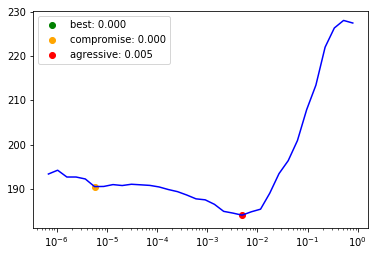

In [9]:
trainer.lr_find(num_steps=100, show=True)